In [1]:
import pandas as pd
import numpy as np
import os
import json

In [2]:
os.getcwd()

'C:\\Users\\maheshw\\Documents\\NPL'

In [4]:
path='C:\\Users\\maheshw\\Documents\\NPL'
os.chdir(path)

In [5]:
with open('Task_sample_data.json') as f:
    data = f.readlines()
    
task_data = [eval(c) for c in data]
task_data = pd.DataFrame(task_data)
task_data.head(5)

,event_type,item_id,timestamp,user_id
0,TRY,bd3a5b18-768f-4dc5-b781-8e4907b84b01,2021-02-27 20:52:35.703546,3adfd314-72d7-11eb-a7f2-f976f6c1d51c
1,OPEN,20545457-3219-44ea-b8a4-3dec8a7b11ab,2021-03-12 11:50:29.110644,3ade3c53-72d7-11eb-a7f2-f976f6c1d51c
2,SUBMIT,20545457-3219-44ea-b8a4-3dec8a7b11ab,2021-02-27 10:20:24.514306,3ae3308e-72d7-11eb-a7f2-f976f6c1d51c
3,HINT,9d2acdd9-1097-43ad-9c7e-92f46a5ef2b5,2021-03-05 02:16:30.852026,3ae4f1ce-72d7-11eb-a7f2-f976f6c1d51c
4,OPEN,f0732e1c-ed0c-4713-86f3-ef448f684be3,2021-02-20 21:44:29.454150,3ae4f160-72d7-11eb-a7f2-f976f6c1d51c


In [6]:
#task_data.to_csv('1.csv',index=False)

In [6]:
df=task_data

In [16]:
#df[df['user_id']=='3ad925f3-72d7-11eb-a7f2-f976f6c1d51c']

,event_type,item_id,timestamp,user_id,event_order
3041,TRY,f0732e1c-ed0c-4713-86f3-ef448f684be3,2021-03-01 10:06:07.325762,3ad925f3-72d7-11eb-a7f2-f976f6c1d51c,2
9136,TRY,f0732e1c-ed0c-4713-86f3-ef448f684be3,2021-03-01 10:21:54.924778,3ad925f3-72d7-11eb-a7f2-f976f6c1d51c,1
27609,SUBMIT,f0732e1c-ed0c-4713-86f3-ef448f684be3,2021-03-01 10:28:47.941012,3ad925f3-72d7-11eb-a7f2-f976f6c1d51c,1


In [7]:
df['event_order'] = df.sort_values(['timestamp'], ascending=False).groupby(['user_id','item_id','event_type']).cumcount() + 1

In [8]:
#df['event_order'] = df['event_type'].str.cat(df['event_order'].astype(str),sep=" ")
columns=['user_id','item_id','event_type','event_order']

In [10]:
#tries
df_try=df[df['event_type']=='TRY'][['user_id','item_id','event_order']]
df_try=df_try.groupby(by=['user_id','item_id']).max().rename(columns={'event_order':'tries'})
df_try.head(2)

,,tries
user_id,item_id,
3ad925ee-72d7-11eb-a7f2-f976f6c1d51c,7ca5c12f-22f9-46e0-bb23-75b73d2e7953,1
3ad925f0-72d7-11eb-a7f2-f976f6c1d51c,f0732e1c-ed0c-4713-86f3-ef448f684be3,4


In [11]:
#hints
df_hint=df[df['event_type']=='HINT'][['user_id','item_id','event_order']]
df_hint=df_hint.groupby(by=['user_id','item_id']).max().rename(columns={'event_order':'hints'})
df_hint.head(2)

,,hints
user_id,item_id,
3ad925f4-72d7-11eb-a7f2-f976f6c1d51c,bd3a5b18-768f-4dc5-b781-8e4907b84b01,1
3ad925f7-72d7-11eb-a7f2-f976f6c1d51c,20545457-3219-44ea-b8a4-3dec8a7b11ab,2


In [25]:
#duration
df_duration=df[(df['event_type']=='OPEN') | (df['event_type']=='SUBMIT')]
#df_duration.pivot(index=['user_id','item_id'],columns='event_type',values='timestamp')


#https://stackoverflow.com/questions/35414625/pandas-how-to-run-a-pivot-with-a-multi-index
def multiindex_pivot(df, index=None, columns=None, values=None):
    if index is None:
        names = list(df.index.names)
        df = df.reset_index()
    else:
        names = index
    list_index = df[names].values
    tuples_index = [tuple(i) for i in list_index] # hashable
    df = df.assign(tuples_index=tuples_index)
    df = df.pivot(index="tuples_index", columns=columns, values=values)
    tuples_index = df.index  # reduced
    index = pd.MultiIndex.from_tuples(tuples_index, names=names)
    df.index = index
    return df

df_duration=df_duration.pipe(multiindex_pivot, index=['user_id','item_id'],columns='event_type',values='timestamp')
df_duration['Item_Duration']= (pd.to_datetime(df_duration['SUBMIT'])-pd.to_datetime(df_duration['OPEN'])).astype('timedelta64[m]')
#df_duration[df_duration['timestamp'].isna()]

In [27]:

df_final=pd.merge(
    pd.merge(df_duration,df_try,on=['user_id','item_id'], how='left')
                    ,df_hint,on=['user_id','item_id'], how='left')
df_final=df_final.reset_index()

#remove the records where OPEN or SUBMIT time not available 
df_final=df_final[df_final['OPEN'].notnull() & df_final['SUBMIT'].notnull()].fillna(0)


In [28]:
df_final.head(10)

,user_id,item_id,OPEN,SUBMIT,Item_Duration,tries,hints
0,3ad925ee-72d7-11eb-a7f2-f976f6c1d51c,7ca5c12f-22f9-46e0-bb23-75b73d2e7953,2021-03-18 17:47:07.305979,2021-03-18 18:03:28.538447,16.0,1.0,0.0
1,3ad925ef-72d7-11eb-a7f2-f976f6c1d51c,7ca5c12f-22f9-46e0-bb23-75b73d2e7953,2021-02-21 11:53:40.686498,2021-02-21 11:59:48.809252,6.0,0.0,0.0
2,3ad925f0-72d7-11eb-a7f2-f976f6c1d51c,f0732e1c-ed0c-4713-86f3-ef448f684be3,2021-03-11 16:53:56.184209,2021-03-11 17:51:22.912193,57.0,4.0,0.0
3,3ad925f1-72d7-11eb-a7f2-f976f6c1d51c,7ca5c12f-22f9-46e0-bb23-75b73d2e7953,2021-03-23 10:19:39.367686,2021-03-23 10:31:00.881277,11.0,2.0,0.0
4,3ad925f2-72d7-11eb-a7f2-f976f6c1d51c,8616387f-0093-4df8-811c-8a50a0b0bbf8,2021-03-26 05:43:09.043607,2021-03-26 06:02:20.987593,19.0,1.0,0.0
7,3ad925f5-72d7-11eb-a7f2-f976f6c1d51c,bd3a5b18-768f-4dc5-b781-8e4907b84b01,2021-02-24 18:48:11.488639,2021-02-24 19:17:42.463410,29.0,0.0,0.0
8,3ad925f6-72d7-11eb-a7f2-f976f6c1d51c,f0732e1c-ed0c-4713-86f3-ef448f684be3,2021-02-22 02:58:38.237589,2021-02-22 03:31:33.615802,32.0,4.0,0.0
9,3ad925f7-72d7-11eb-a7f2-f976f6c1d51c,20545457-3219-44ea-b8a4-3dec8a7b11ab,2021-03-25 02:31:30.973294,2021-03-25 02:54:28.499356,22.0,0.0,2.0
10,3ad925f8-72d7-11eb-a7f2-f976f6c1d51c,9d2acdd9-1097-43ad-9c7e-92f46a5ef2b5,2021-03-25 23:48:52.831403,2021-03-26 00:08:31.517126,19.0,2.0,0.0
11,3ad925f9-72d7-11eb-a7f2-f976f6c1d51c,7ca5c12f-22f9-46e0-bb23-75b73d2e7953,2021-03-22 14:25:33.986661,2021-03-22 14:38:12.980853,12.0,0.0,2.0


In [29]:
df_final.describe()

,Item_Duration,tries,hints
count,7433.000000,7433.000000,7433.000000
mean,28.799812,0.981838,0.417194
std,17.389030,1.381026,0.762700
min,0.000000,0.000000,0.000000
25%,16.000000,0.000000,0.000000
50%,28.000000,0.000000,0.000000
75%,40.000000,1.000000,1.000000
max,108.000000,11.000000,6.000000


In [ ]:
#75% have answered conrectly in the first attempt without using any hints 
# average time 

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns


(array([1280., 1314., 1940., 1472.,  796.,  407.,  141.,   59.,   21.,
           3.]),
 array([  0. ,  10.8,  21.6,  32.4,  43.2,  54. ,  64.8,  75.6,  86.4,
         97.2, 108. ]),
 <a list of 10 Patch objects>)

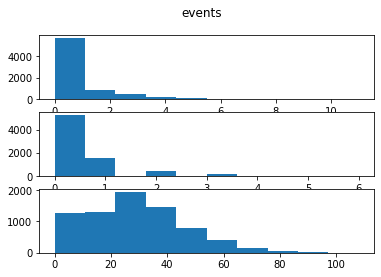

In [31]:
fig, axs = plt.subplots(3)
fig.suptitle('events')
axs[0].hist(df_final['tries'])
axs[1].hist(df_final['hints'])
axs[2].hist(df_final['Item_Duration'])

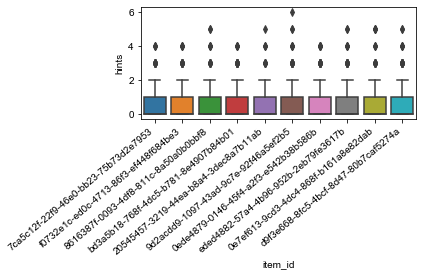

In [32]:
ax=sns.boxplot(data=df_final, x='item_id', y='hints')
sns.set(rc={'figure.figsize':(10,8)})

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

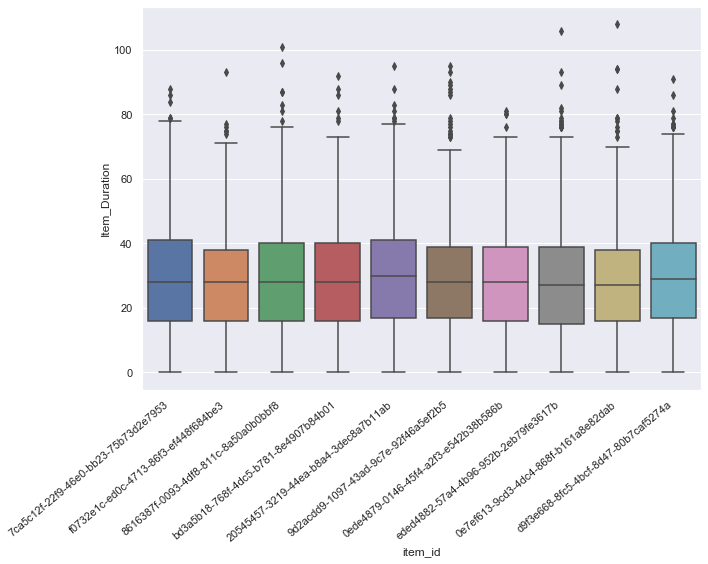

In [33]:
ax=sns.boxplot(data=df_final, x='item_id', y='Item_Duration')
sns.set(rc={'figure.figsize':(10,8)})

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
# Distribution of time spent for each question is almost same. 
#Considering the median would be more accurate as the distribution is bit skewed, but 

In [34]:
df_final[['item_id','Item_Duration']].groupby(by=['item_id']).describe()

Item_Duration                             \
                                             count       mean        std  min   
item_id                                                                         
0e7ef613-9cd3-4dc4-868f-b161a8e82dab         732.0  27.790984  17.017856  0.0   
0ede4879-0146-45f4-a2f3-e542b38b586b         733.0  28.162347  16.723061  0.0   
20545457-3219-44ea-b8a4-3dec8a7b11ab         726.0  29.793388  17.322857  0.0   
7ca5c12f-22f9-46e0-bb23-75b73d2e7953         765.0  28.962092  17.346783  0.0   
8616387f-0093-4df8-811c-8a50a0b0bbf8         731.0  28.935705  17.948098  0.0   
9d2acdd9-1097-43ad-9c7e-92f46a5ef2b5         770.0  29.127273  17.529004  0.0   
bd3a5b18-768f-4dc5-b781-8e4907b84b01         752.0  29.105053  17.415526  0.0   
d9f3e668-8fc5-4bcf-8d47-80b7caf5274a         754.0  29.335544  17.471666  0.0   
eded4882-57a4-4b96-952b-2eb79fe3617b         759.0  28.567852  18.359150  0.0   
f0732e1c-ed0c-4713-86f3-ef448f684be3         711.0  28.168776  16.629591  0.0   

                                                               
                                       25%   50%   75%    max  
item_id                                                        
0e7ef613-9cd3-4dc4-868f-b161a8e82dab  16.0  27.0  38.0  108.0  
0ede4879-0146-45f4-a2f3-e542b38b586b  16.0  28.0  39.0   81.0  
20545457-3219-44ea-b8a4-3dec8a7b11ab  17.0  30.0  41.0   95.0  
7ca5c12f-22f9-46e0-bb23-75b73d2e7953  16.0  28.0  41.0   88.0  
8616387f-0093-4df8-811c-8a50a0b0bbf8  16.0  28.0  40.0  101.0  
9d2acdd9-1097-43ad-9c7e-92f46a5ef2b5  17.0  28.0  39.0   95.0  
bd3a5b18-768f-4dc5-b781-8e4907b84b01  16.0  28.0  40.0   92.0  
d9f3e668-8fc5-4bcf-8d47-80b7caf5274a  17.0  29.0  40.0   91.0  
eded4882-57a4-4b96-952b-2eb79fe3617b  15.0  27.0  39.0  106.0  
f0732e1c-ed0c-4713-86f3-ef448f684be3  16.0  28.0  38.0   93.0

In [187]:
df_final[['item_id','tries','hints']].groupby(by=['item_id']).describe()

tries                                \
                                      count      mean       std  min  25%   
item_id                                                                     
0e7ef613-9cd3-4dc4-868f-b161a8e82dab  732.0  0.968579  1.394869  0.0  0.0   
0ede4879-0146-45f4-a2f3-e542b38b586b  733.0  1.006821  1.349441  0.0  0.0   
20545457-3219-44ea-b8a4-3dec8a7b11ab  726.0  1.015152  1.398932  0.0  0.0   
7ca5c12f-22f9-46e0-bb23-75b73d2e7953  765.0  0.956863  1.408453  0.0  0.0   
8616387f-0093-4df8-811c-8a50a0b0bbf8  731.0  0.901505  1.311126  0.0  0.0   
9d2acdd9-1097-43ad-9c7e-92f46a5ef2b5  770.0  1.018182  1.425089  0.0  0.0   
bd3a5b18-768f-4dc5-b781-8e4907b84b01  752.0  0.969415  1.286153  0.0  0.0   
d9f3e668-8fc5-4bcf-8d47-80b7caf5274a  754.0  1.011936  1.431431  0.0  0.0   
eded4882-57a4-4b96-952b-2eb79fe3617b  759.0  0.969697  1.390840  0.0  0.0   
f0732e1c-ed0c-4713-86f3-ef448f684be3  711.0  1.000000  1.408225  0.0  0.0   

                                                      hints            \
                                      50%  75%   max  count      mean   
item_id                                                                 
0e7ef613-9cd3-4dc4-868f-b161a8e82dab  0.0  1.0   8.0  732.0  0.387978   
0ede4879-0146-45f4-a2f3-e542b38b586b  1.0  2.0  10.0  733.0  0.462483   
20545457-3219-44ea-b8a4-3dec8a7b11ab  1.0  2.0   9.0  726.0  0.407713   
7ca5c12f-22f9-46e0-bb23-75b73d2e7953  0.0  1.0  10.0  765.0  0.389542   
8616387f-0093-4df8-811c-8a50a0b0bbf8  0.0  1.0  11.0  731.0  0.381669   
9d2acdd9-1097-43ad-9c7e-92f46a5ef2b5  0.0  1.0   8.0  770.0  0.463636   
bd3a5b18-768f-4dc5-b781-8e4907b84b01  1.0  2.0   8.0  752.0  0.428191   
d9f3e668-8fc5-4bcf-8d47-80b7caf5274a  1.0  1.0   9.0  754.0  0.404509   
eded4882-57a4-4b96-952b-2eb79fe3617b  0.0  1.0   8.0  759.0  0.418972   
f0732e1c-ed0c-4713-86f3-ef448f684be3  1.0  1.0   9.0  711.0  0.426160   

                                                                         
                                           std  min  25%  50%  75%  max  
item_id                                                                  
0e7ef613-9cd3-4dc4-868f-b161a8e82dab  0.777430  0.0  0.0  0.0  1.0  5.0  
0ede4879-0146-45f4-a2f3-e542b38b586b  0.789461  0.0  0.0  0.0  1.0  4.0  
20545457-3219-44ea-b8a4-3dec8a7b11ab  0.713724  0.0  0.0  0.0  1.0  5.0  
7ca5c12f-22f9-46e0-bb23-75b73d2e7953  0.712562  0.0  0.0  0.0  1.0  4.0  
8616387f-0093-4df8-811c-8a50a0b0bbf8  0.744399  0.0  0.0  0.0  1.0  5.0  
9d2acdd9-1097-43ad-9c7e-92f46a5ef2b5  0.820322  0.0  0.0  0.0  1.0  6.0  
bd3a5b18-768f-4dc5-b781-8e4907b84b01  0.765538  0.0  0.0  0.0  1.0  4.0  
d9f3e668-8fc5-4bcf-8d47-80b7caf5274a  0.765824  0.0  0.0  0.0  1.0  5.0  
eded4882-57a4-4b96-952b-2eb79fe3617b  0.769442  0.0  0.0  0.0  1.0  5.0  
f0732e1c-ed0c-4713-86f3-ef448f684be3  0.759794  0.0  0.0  0.0  1.0  4.0

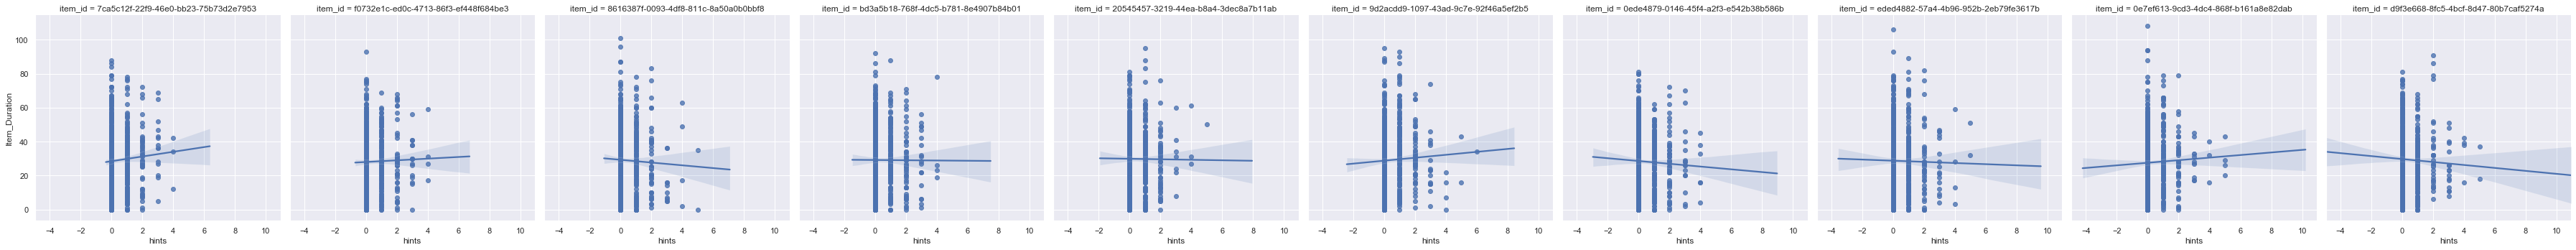

In [35]:
sns.lmplot(data=df_final, x="hints", y="Item_Duration", col="item_id")#, hue="smoker")

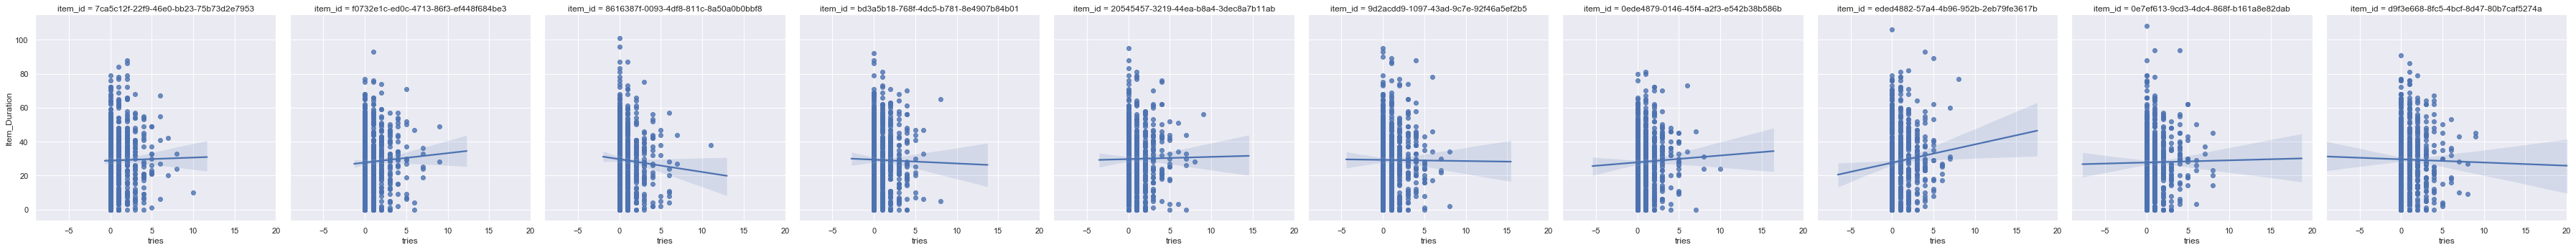

In [36]:
sns.lmplot(data=df_final, x="tries", y="Item_Duration", col="item_id")#, hue="smoker")

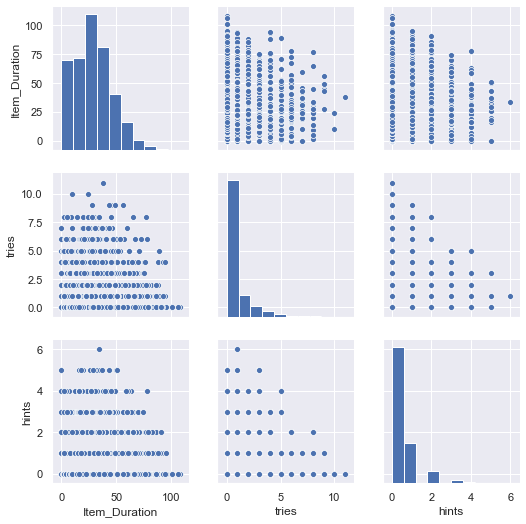

In [37]:
sns.pairplot(data=df_final)

In [42]:
from scipy import stats  as st

print(st.skew(df_final['Item_Duration'])) #approximatly symetric
print(st.kurtosis(df_final['Item_Duration'])) #close to zero
print(st.normaltest(df_final['Item_Duration'])) # p Value < 0.05 

0.4845329771738419
0.16798398263891068
NormaltestResult(statistic=270.2647347990863, pvalue=2.054747741952399e-59)


In [50]:
from scipy import stats
stats.f_oneway(df_final[df_final['item_id']=='0e7ef613-9cd3-4dc4-868f-b161a8e82dab']['Item_Duration'], 
                   df_final[df_final['item_id']=='0ede4879-0146-45f4-a2f3-e542b38b586b']['Item_Duration'],
                        df_final[df_final['item_id']=='20545457-3219-44ea-b8a4-3dec8a7b11ab']['Item_Duration'],         
                        df_final[df_final['item_id']=='7ca5c12f-22f9-46e0-bb23-75b73d2e7953']['Item_Duration'],
                        df_final[df_final['item_id']=='8616387f-0093-4df8-811c-8a50a0b0bbf8']['Item_Duration'],
                        df_final[df_final['item_id']=='9d2acdd9-1097-43ad-9c7e-92f46a5ef2b5']['Item_Duration'],
                        df_final[df_final['item_id']=='bd3a5b18-768f-4dc5-b781-8e4907b84b01']['Item_Duration'],
                        df_final[df_final['item_id']=='d9f3e668-8fc5-4bcf-8d47-80b7caf5274a']['Item_Duration'],
                        df_final[df_final['item_id']=='f0732e1c-ed0c-4713-86f3-ef448f684be3']['Item_Duration'],
                        df_final[df_final['item_id']=='eded4882-57a4-4b96-952b-2eb79fe3617b']['Item_Duration']
               
)


F_onewayResult(statistic=0.913473969533054, pvalue=0.5120781866438215)

In [54]:
stats.f_oneway(df_final[df_final['item_id']=='0e7ef613-9cd3-4dc4-868f-b161a8e82dab']['Item_Duration'], 
                   df_final[df_final['item_id']=='0ede4879-0146-45f4-a2f3-e542b38b586b']['Item_Duration'],
                        df_final[df_final['item_id']=='20545457-3219-44ea-b8a4-3dec8a7b11ab']['tries'],         
                        df_final[df_final['item_id']=='7ca5c12f-22f9-46e0-bb23-75b73d2e7953']['tries'],  
                        df_final[df_final['item_id']=='8616387f-0093-4df8-811c-8a50a0b0bbf8']['tries'],  
                        df_final[df_final['item_id']=='9d2acdd9-1097-43ad-9c7e-92f46a5ef2b5']['tries'],  
                        df_final[df_final['item_id']=='bd3a5b18-768f-4dc5-b781-8e4907b84b01']['tries'],  
                        df_final[df_final['item_id']=='d9f3e668-8fc5-4bcf-8d47-80b7caf5274a']['tries'],  
                        df_final[df_final['item_id']=='f0732e1c-ed0c-4713-86f3-ef448f684be3']['tries'],  
                        df_final[df_final['item_id']=='eded4882-57a4-4b96-952b-2eb79fe3617b']['tries']
               
)

F_onewayResult(statistic=1652.7765638134645, pvalue=0.0)

In [52]:
stats.f_oneway(df_final[df_final['item_id']=='0e7ef613-9cd3-4dc4-868f-b161a8e82dab']['Item_Duration'], 
                   df_final[df_final['item_id']=='0ede4879-0146-45f4-a2f3-e542b38b586b']['Item_Duration'],
                        df_final[df_final['item_id']=='20545457-3219-44ea-b8a4-3dec8a7b11ab']['hints'],         
                        df_final[df_final['item_id']=='7ca5c12f-22f9-46e0-bb23-75b73d2e7953']['hints'],
                        df_final[df_final['item_id']=='8616387f-0093-4df8-811c-8a50a0b0bbf8']['hints'],
                        df_final[df_final['item_id']=='9d2acdd9-1097-43ad-9c7e-92f46a5ef2b5']['hints'],
                        df_final[df_final['item_id']=='bd3a5b18-768f-4dc5-b781-8e4907b84b01']['hints'],
                        df_final[df_final['item_id']=='d9f3e668-8fc5-4bcf-8d47-80b7caf5274a']['hints'],
                        df_final[df_final['item_id']=='f0732e1c-ed0c-4713-86f3-ef448f684be3']['hints'],
                        df_final[df_final['item_id']=='eded4882-57a4-4b96-952b-2eb79fe3617b']['hints']
               
)

F_onewayResult(statistic=1755.47924863596, pvalue=0.0)

In [48]:
from scipy import stats
stats.ttest_ind(df_final[df_final['item_id']=='0e7ef613-9cd3-4dc4-868f-b161a8e82dab']['Item_Duration'], 
                   df_final[df_final['item_id']=='0ede4879-0146-45f4-a2f3-e542b38b586b']['Item_Duration'])
                       

Ttest_indResult(statistic=-0.421256275239851, pvalue=0.6736298350447122)